This version "m4_v5" is with an input of 9 variables where we removed the chi2 of the Kaon and the instentanious intensity Lambda. We will start by training a (9,530,200,1) FCNN.


In [2]:
# %load m4_v3.py
#!/usr/bin/env python3
"""
Created on Thu Aug 23 10:46:07 2018

@author: jcarmignani
"""

# -*- coding: utf-8 -*-
"""
Created on Sat Jun 23 20:42:37 2018

@author: J_Carmignani


"""
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import math
import h5py
import sklearn
import sklearn.datasets
import sklearn.linear_model



#reg_utils-------------------------------------------------------------------------------------------------------------------

def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    """
    Compute the relu of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    
    return s



def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    b1 -- bias vector of shape (layer_dims[l], 1)
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l])
                    
    Tips:
    - For example: the layer_dims for the "Planar Data classification model" would have been [2,2,1]. 
    This means W1's shape was (2,2), b1 was (1,2), W2 was (2,1) and b2 was (1,1). Now you have to generalize it!
    - In the for loop, use parameters['W' + str(l)] to access Wl, where l is the iterative integer.
    """
    
    np.random.seed(3)
    #m = X.shape[1] # number of examples
    #layers_dims = [4, 10, 3, 1]
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = (np.random.randn(layer_dims[l], layer_dims[l-1]))*(np.sqrt(2./ (layer_dims[l-1])))
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    #assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
    #assert(parameters['W' + str(l)].shape == layer_dims[l], 1)

        
    return parameters


def random_mini_batches(X, Y, mini_batch_size = 256, seed = 0):
    np.random.seed(seed)
    m = X.shape[1] # number of training examples
    mini_batches = []
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batchesof size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):

        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
# Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X [:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y [:, num_complete_minibatches * mini_batch_size : m]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches



def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
        
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)+1e-8
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

def compute_cost(A3, Y):
    
    """
    Implement the cost function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    cost - value of the cost function
    """
    m = Y.shape[1]
    a=np.reshape(A3,(1,m))
    #logprobs = (np.multiply(-(np.log(a)),Y) + np.multiply(-(np.log(1 - a)),(1 - Y)))
    cost = (np.nansum((np.multiply(-(np.log(a)),Y) + np.multiply(-(np.log(1 - a)),(1 - Y)))))*(1./m)
    
    return cost


def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 =(1./m) * (A3 - Y)
    dW3 = np.dot(dZ3, A2.T)
    db3 = np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.float64(A2 > 0))
    dW2 = np.dot(dZ2, A1.T)
    db2 = np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.float64(A1 > 0))
    dW1 = np.dot(dZ1, X.T)
    db1 = np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

def initialize_adam(parameters) :
   """
   Initializes v and s as two python dictionaries with:
   - keys: "dW1", "db1", ..., "dWL", "dbL"
   - values: numpy arrays of zeros of the same shape as the corresponding
   gradients/parameters.
   Arguments:
   parameters -- python dictionary containing your parameters.
   parameters["W" + str(l)] = Wl
   parameters["b" + str(l)] = bl
   Returns:
   v -- python dictionary that will contain the exponentially weighted average of the
   gradient.
   v["dW" + str(l)] = ...
   v["db" + str(l)] = ...
   s -- python dictionary that will contain the exponentially weighted average of the
   squared gradient.
   s["dW" + str(l)] = ...
   s["db" + str(l)] = ...
   """

   L = len(parameters) // 2 # number of layers in the neural networks
   v = {}
   s = {}
# Initialize v, s. Input: "parameters". Outputs: "v, s".
   for l in range(L):
### START CODE HERE ### (approx. 4 lines)
       v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape))
       v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape))
       s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape))
       s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape))
### END CODE HERE ###
   return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 1e-7,
beta1 = 0.9, beta2 = 0.99, epsilon = 1e-8):
   """
   Update parameters using Adam
   Arguments:
   parameters -- python dictionary containing your parameters:
   parameters['W' + str(l)] = Wl
   parameters['b' + str(l)] = bl
   grads -- python dictionary containing your gradients for each parameters:
   grads['dW' + str(l)] = dWl
   grads['db' + str(l)] = dbl
   v -- Adam variable, moving average of the first gradient, python dictionary
   s -- Adam variable, moving average of the squared gradient, python dictionary
   learning_rate -- the learning rate, scalar.
   beta1 -- Exponential decay hyperparameter for the first moment estimates
   beta2 -- Exponential decay hyperparameter for the second moment estimates
   epsilon -- hyperparameter preventing division by zero in Adam updates
   Returns:
   parameters -- python dictionary containing your updated parameters
   v -- Adam variable, moving average of the first gradient, python dictionary
   s -- Adam variable, moving average of the squared gradient, python dictionary
   """
   L = len(parameters) // 2 # number of layers in the neural networks
   v_corrected = {} # Initializing first moment estimate, python dictionary
   s_corrected = {} # Initializing second moment estimate, python dictionary
# Perform Adam update on all parameters
   for l in range(L):
# Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
      v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)]+(1-beta1)*grads["dW" + str(l+1)]
      v["db" + str(l+1)] = beta1*v["db" + str(l+1)]+(1-beta1)*grads["db" + str(l+1)]
      v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-beta1**t)
      v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-beta1**t)
      s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)]+(1-beta2)*((grads["dW" + str(l+1)])**2)
      s["db" + str(l+1)] = beta2*s["db" + str(l+1)]+(1-beta2)*((grads["db" + str(l+1)])**2)
      s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-beta2**t)
      s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-beta2**t)
      parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*v_corrected["dW" + str(l+1)]/((s_corrected["dW" + str(l+1)])**0.5 + epsilon)
      parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*v_corrected["db" + str(l+1)]/((s_corrected["db" + str(l+1)])**0.5 + epsilon)
       
   return parameters, v, s

   
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    A3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    file1=open("misspredictions_m4v5_Kaon.txt","w")
    file2=open("misspredictions_m4v5_Pileup.txt","w")

    for i in range(0, A3.shape[1]):
        if A3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print/save results
    for j in range(0, A3.shape[1]):
        if p[0,j] == y[0,j]:
            continue
        else:
            if p[0,j] == 1:
                file1.write(str(j)+ " " + str(p[0,j])+"\n")
            else:
                file2.write(str(j)+ " " + str(p[0,j])+"\n")
    file1.close()
    file2.close()
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p
    


def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    A3, cache = forward_propagation(X, parameters)
    predictions = (A3>0.5)
    return predictions


    
  #plt.scatter(train_X[2, :], train_X[3, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
   




#11vars-----------------------------------------------------------------------------------------------------------------------

tchod1= np.genfromtxt("tCHODS1.txt",skip_footer=(46746),usecols=(1),unpack=True)

tchod1_test= np.genfromtxt("tCHODS1.txt",skip_header=(420709),usecols=(1),unpack=True)

trich1= np.genfromtxt("tRICHS1.txt",skip_footer=(46746),usecols=(1),unpack=True)

trich1_test= np.genfromtxt("tRICHS1.txt",skip_header=(420709),usecols=(1),unpack=True)

tgtk1= np.genfromtxt("tGTKS1.txt",skip_footer=(46746),usecols=(1),unpack=True)

tgtk1_test= np.genfromtxt("tGTKS1.txt",skip_header=(420709),usecols=(1),unpack=True)

tktag1= np.genfromtxt("tKTAGS1.txt",skip_footer=(46746),usecols=(1),unpack=True)

tktag1_test= np.genfromtxt("tKTAGS1.txt",skip_header=(420709),usecols=(1),unpack=True)

cda1= np.genfromtxt("CDAS1.txt",skip_footer=(46746),usecols=(1),unpack=True)

cda1_test= np.genfromtxt("CDAS1.txt",skip_header=(420709),usecols=(1),unpack=True)

chi21= np.genfromtxt("CHI2S1.txt",skip_footer=(46746),usecols=(1),unpack=True)

chi21_test= np.genfromtxt("CHI2S1.txt",skip_header=(420709),usecols=(1),unpack=True)

chi2p1= np.genfromtxt("CHI2PS1.txt",skip_footer=(46746),usecols=(1),unpack=True)

chi2p1_test= np.genfromtxt("CHI2PS1.txt",skip_header=(420709),usecols=(1),unpack=True)

lamd1= np.genfromtxt("LAMBDAS1.txt",skip_footer=(46746),usecols=(1),unpack=True)
lamd1_test= np.genfromtxt("LAMBDAS1.txt",skip_header=(420709),usecols=(1),unpack=True)

dx1= np.genfromtxt("DXS1.txt",skip_footer=(46746),usecols=(1),unpack=True)

dx1_test= np.genfromtxt("DXS1.txt",skip_header=(420709),usecols=(1),unpack=True)

dy1= np.genfromtxt("DYS1.txt",skip_footer=(46746),usecols=(1),unpack=True)
dy1_test= np.genfromtxt("DYS1.txt",skip_header=(420709),usecols=(1),unpack=True)

vtrx1= np.genfromtxt("VTRXS1.txt",skip_footer=(46746),usecols=(1),unpack=True)

vtrx1_test= np.genfromtxt("VTRXS1.txt",skip_header=(420709),usecols=(1),unpack=True)

vtry1= np.genfromtxt("VTRYS1.txt",skip_footer=(46746),usecols=(1),unpack=True)

vtry1_test= np.genfromtxt("VTRYS1.txt",skip_header=(420709),usecols=(1),unpack=True)

tchod0= np.genfromtxt("tCHODB1.txt",skip_footer=(128354),usecols=(1),unpack=True)
tchod0_test= np.genfromtxt("tCHODB1.txt",skip_header=(1155182),usecols=(1),unpack=True)
trich0= np.genfromtxt("tRICHB1.txt",skip_footer=(128354),usecols=(1),unpack=True)
trich0_test= np.genfromtxt("tRICHB1.txt",skip_header=(1155182),usecols=(1),unpack=True)
tgtk0= np.genfromtxt("tGTKB1.txt",skip_footer=(128354),usecols=(1),unpack=True)
tgtk0_test= np.genfromtxt("tGTKB1.txt",skip_header=(1155182),usecols=(1),unpack=True)
tktag0= np.genfromtxt("tKTAGB1.txt",skip_footer=(128354),usecols=(1),unpack=True)
tktag0_test= np.genfromtxt("tKTAGB1.txt",skip_header=(1155182),usecols=(1),unpack=True)
cda0= np.genfromtxt("CDAB1.txt",skip_footer=(128354),usecols=(1),unpack=True)
cda0_test= np.genfromtxt("CDAB1.txt",skip_header=(1155182),usecols=(1),unpack=True)
chi20= np.genfromtxt("CHI2B1.txt",skip_footer=(128354),usecols=(1),unpack=True)
chi20_test= np.genfromtxt("CHI2B1.txt",skip_header=(1155182),usecols=(1),unpack=True)
chi2p0= np.genfromtxt("CHI2PB1.txt",skip_footer=(128354),usecols=(1),unpack=True)
chi2p0_test= np.genfromtxt("CHI2PB1.txt",skip_header=(1155182),usecols=(1),unpack=True)
lamd0= np.genfromtxt("LAMBDAB1.txt",skip_footer=(128354),usecols=(1),unpack=True)
lamd0_test= np.genfromtxt("LAMBDAB1.txt",skip_header=(1155182),usecols=(1),unpack=True)
dx0= np.genfromtxt("DXB1.txt",skip_footer=(128354),usecols=(1),unpack=True)
dx0_test= np.genfromtxt("DXB1.txt",skip_header=(1155182),usecols=(1),unpack=True)
dy0= np.genfromtxt("DYB1.txt",skip_footer=(128354),usecols=(1),unpack=True)
dy0_test= np.genfromtxt("DYB1.txt",skip_header=(1155182),usecols=(1),unpack=True)
vtrx0= np.genfromtxt("VTRXB1.txt",skip_footer=(128354),usecols=(1),unpack=True)
vtrx0_test= np.genfromtxt("VTRXB1.txt",skip_header=(1155182),usecols=(1),unpack=True)
vtry0= np.genfromtxt("VTRYB1.txt",skip_footer=(128354),usecols=(1),unpack=True)
vtry0_test= np.genfromtxt("VTRYB1.txt",skip_header=(1155182),usecols=(1),unpack=True)
deltatchod1=tchod1-tgtk1
deltatchod1_test=tchod1_test-tgtk1_test
deltatrich1=trich1-tgtk1
deltatrich1_test=trich1_test-tgtk1_test
deltatchod0=tchod0-tgtk0
deltatchod0_test=tchod0_test-tgtk0_test
deltatrich0=trich0-tgtk0
deltatrich0_test=trich0_test-tgtk0_test
deltatktag0=tktag0-tgtk0
deltatktag0_test=tktag0_test-tgtk0_test
deltatktag1=tktag1-tgtk1
deltatktag1_test=tktag1_test-tgtk1_test


#--------------------------------------------------------------------------------------------------------------------------------
deltatrich=np.hstack((deltatrich0,deltatrich1))
deltatchod=np.hstack((deltatchod0,deltatchod1))
deltatktag=np.hstack((deltatktag0,deltatktag1))
deltatrich_test=np.hstack((deltatrich0_test,deltatrich1_test)) 
deltatchod_test=np.hstack((deltatchod0_test,deltatchod1_test)) 
deltatktag_test=np.hstack((deltatktag0_test,deltatktag1_test)) 
cda=np.hstack((cda0,cda1))
chi2=np.hstack((chi20,chi21))
chi2p=np.hstack((chi2p0,chi2p1))
lamd=np.hstack((lamd0,lamd1))
dx=np.hstack((dx0,dx1))
dy=np.hstack((dy0,dy1))
vtrx=np.hstack((vtrx0,vtrx1))
vtry=np.hstack((vtry0,vtry1))
cda_test=np.hstack((cda0_test,cda1_test))
chi2_test=np.hstack((chi20_test,chi21_test))
chi2p_test=np.hstack((chi2p0_test,chi2p1_test))
lamd_test=np.hstack((lamd0_test,lamd1_test))
dx_test=np.hstack((dx0_test,dx1_test))
dy_test=np.hstack((dy0_test,dy1_test))
vtrx_test=np.hstack((vtrx0_test,vtrx1_test))
vtry_test=np.hstack((vtry0_test,vtry1_test))

#--------------------------------------------------------------------------------------------------------------------------------------


#For Background train
mask00= (-1< deltatchod0) & (deltatchod0<1)
x00a=deltatchod0[mask00]
mask10= (-1< deltatrich0) & (deltatrich0<1)
x10=deltatrich0[mask10]
mask20= (-1< deltatktag0) & (deltatktag0<1)
x20a=deltatktag0[mask20]
mask30a= (cda0<15)
x30a=cda0[mask30a]

#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#'' x00a.shape                                                                    ''
#'' x10.shape                                                                     ''
#'' x20a.shape                                                                    ''
#'' x30a.shape#to check the dimentionality then take the lowest dim mask for all  ''
#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


x00=deltatchod0[mask10]
x20=deltatktag0[mask10]# to fix the cut having the same shape
x30=cda0[mask10]
mask30=(x30<15)#fix the condition for mask30




x330=x30[mask30]#if lower dim apply it again for all
x220=x20[mask30]
x110=x10[mask30]
x000=x00[mask30]
#continue the same for all the other variables to unify the dimensions
x40=chi20[mask10]
x440=x40[mask30]
x50=chi2p0[mask10]
x550=x50[mask30]
x60=lamd0[mask10]
x660=x60[mask30]
x70=dx0[mask10]
x770=x70[mask30]
x80=dy0[mask10]
x880=x80[mask30]
x90=vtrx0[mask10]
x990=x90[mask30]
y90=vtry0[mask10]
y990=y90[mask30]

nx000=(x000)#-min(x000))/(max(x000)-min(x000))
nx110=(x110)#-min(x110))/(max(x110)-min(x110))
nx220=(x220)#-min(x220))/(max(x220)-min(x220))
nx330=(x330)#-min(x330))/(max(x330)-min(x330))
nx440=(x440)#-min(x440))/(max(x440)-min(x440))
nx550=(x550)#-min(x550))/(max(x550)-min(x550))
nx660=(x660)#-min(x660))/(max(x660)-min(x660))
nx770=(x770)#-min(x770))/(max(x770)-min(x770))
nx880=(x880)#-min(x880))/(max(x880)-min(x880))
nx990=(x990)#-min(x990))/(max(x990)-min(x990))
ny990=(y990)#-min(y990))/(max(y990)-min(y990))


z00=np.reshape(nx000,(1,314034))
z10=np.reshape(nx110,(1,314034))
z20=np.reshape(nx220,(1,314034))
z30=np.reshape(nx330,(1,314034))
#z40=np.reshape(nx440,(1,314034))
z50=np.reshape(nx550,(1,314034))
#z60=np.reshape(nx660,(1,314034))
z70=np.reshape(nx770,(1,314034))
z80=np.reshape(nx880,(1,314034))
zx90=np.reshape(nx990,(1,314034))
zy90=np.reshape(ny990,(1,314034))


X0 = np.vstack((z00,z10,z20,z30,z50,z70,z80,zx90,zy90))
Y0=np.zeros((1,X0.shape[1]))





#For Background 0 test
mask00_test= (-1< deltatchod0_test) & (deltatchod0_test<1)
x00a_test=deltatchod0_test[mask00_test]
mask10_test= (-1< deltatrich0_test) & (deltatrich0_test<1)
x10_test=deltatrich0_test[mask10_test]
mask20_test= (-1< deltatktag0_test) & (deltatktag0_test<1)
x20a_test=deltatktag0_test[mask20_test]
mask30a_test= (cda0_test<15)
x30a_test=cda0_test[mask30a_test]

#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#'' x00a_test.shape                                                                    ''
#'' x10_test.shape                                                                     ''
#'' x20a_test.shape                                                                    ''
#'' x30a_test.shape#to check the dimentionality then take the lowest dim mask for all  ''
#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


x00_test=deltatchod0_test[mask10_test]
x20_test=deltatktag0_test[mask10_test]# to fix the cut having the same shape
x30_test=cda0_test[mask10_test]
mask30_test=(x30_test<15)#fix the condition for mask30




x330_test=x30_test[mask30_test]#if lower dim apply it again for all
x220_test=x20_test[mask30_test]
x110_test=x10_test[mask30_test]
x000_test=x00_test[mask30_test]
#continue the same for all the other variables to unify the dimensions
x40_test=chi20_test[mask10_test]
x440_test=x40_test[mask30_test]
x50_test=chi2p0_test[mask10_test]
x550_test=x50_test[mask30_test]
x60_test=lamd0_test[mask10_test]
x660_test=x60_test[mask30_test]
x70_test=dx0_test[mask10_test]
x770_test=x70_test[mask30_test]
x80_test=dy0_test[mask10_test]
x880_test=x80_test[mask30_test]
x90_test=vtrx0_test[mask10_test]
x990_test=x90_test[mask30_test]
y90_test=vtry0_test[mask10_test]
y990_test=y90_test[mask30_test]

nx000_test=(x000_test)#-min(x000_test))/(max(x000_test)-min(x000_test))
nx110_test=(x110_test)#-min(x110_test))/(max(x110_test)-min(x110_test))
nx220_test=(x220_test)#-min(x220_test))/(max(x220_test)-min(x220_test))
nx330_test=(x330_test)#-min(x330_test))/(max(x330_test)-min(x330_test))
nx440_test=(x440_test)#-min(x440_test))/(max(x440_test)-min(x440_test))
nx550_test=(x550_test)#-min(x550_test))/(max(x550_test)-min(x550_test))
nx660_test=(x660_test)#-min(x660_test))/(max(x660_test)-min(x660_test))
nx770_test=(x770_test)#-min(x770_test))/(max(x770_test)-min(x770_test))
nx880_test=(x880_test)#-min(x880_test))/(max(x880_test)-min(x880_test))
nx990_test=(x990_test)#-min(x990_test))/(max(x990_test)-min(x990_test))
ny990_test=(y990_test)#-min(y990_test))/(max(y990_test)-min(y990_test))


z00_test=np.reshape(nx000_test,(1,35001))
z10_test=np.reshape(nx110_test,(1,35001))
z20_test=np.reshape(nx220_test,(1,35001))
z30_test=np.reshape(nx330_test,(1,35001))
#z40_test=np.reshape(nx440_test,(1,35001))
z50_test=np.reshape(nx550_test,(1,35001))
#z60_test=np.reshape(nx660_test,(1,35001))
z70_test=np.reshape(nx770_test,(1,35001))
z80_test=np.reshape(nx880_test,(1,35001))
zx90_test=np.reshape(nx990_test,(1,35001))
zy90_test=np.reshape(ny990_test,(1,35001))


X0_test = np.vstack((z00_test,z10_test,z20_test,z30_test,z50_test,z70_test,z80_test,zx90_test,zy90_test))
Y0_test=np.zeros((1,X0_test.shape[1]))







#For Signal 1 train
mask01= (-1< deltatchod1) & (deltatchod1<1)
x01a=deltatchod1[mask01]
mask11= (-1< deltatrich1) & (deltatrich1<1)
x11=deltatrich1[mask11]
mask21= (-1< deltatktag1) & (deltatktag1<1)
x21a=deltatktag1[mask21]
mask31a= (cda1<15)
x31a=cda1[mask31a]

#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#'' x01a.shape                                                                    ''
#'' x11.shape                                                                     ''
#'' x21a.shape                                                                    ''
#'' x31a.shape#to check the dimentionality then take the lowest dim mask for all  ''
#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


x01=deltatchod1[mask11]
x21=deltatktag1[mask11]# to fix the cut having the same shape
x31=cda1[mask11]
mask31=(x31<15)#fix the condition for mask30




x331=x31[mask31]#if lower dim apply it again for all
x221=x21[mask31]
x111=x11[mask31]
x001=x01[mask31]
#continue the same for all the other variables to unify the dimensions
x41=chi21[mask11]
x441=x41[mask31]
x51=chi2p1[mask11]
x551=x51[mask31]
x61=lamd1[mask11]
x661=x61[mask31]
x71=dx1[mask11]
x771=x71[mask31]
x81=dy1[mask11]
x881=x81[mask31]
x91=vtrx1[mask11]
x991=x91[mask31]
y91=vtry1[mask11]
y991=y91[mask31]

nx001=(x001)#-min(x001))/(max(x001)-min(x001))
nx111=(x111)#-min(x111))/(max(x111)-min(x111))
nx221=(x221)#-min(x221))/(max(x221)-min(x221))
nx331=(x331)#-min(x331))/(max(x331)-min(x331))
nx441=(x441)#-min(x441))/(max(x441)-min(x441))
nx551=(x551)#-min(x551))/(max(x551)-min(x551))
nx661=(x661)#-min(x661))/(max(x661)-min(x661))
nx771=(x771)#-min(x771))/(max(x771)-min(x771))
nx881=(x881)#-min(x881))/(max(x881)-min(x881))
nx991=(x991)#-min(x991))/(max(x991)-min(x991))
ny991=(y991)#-min(y991))/(max(y991)-min(y991))


z01=np.reshape(nx001,(1,417049))
z11=np.reshape(nx111,(1,417049))
z21=np.reshape(nx221,(1,417049))
z31=np.reshape(nx331,(1,417049))
#z41=np.reshape(nx441,(1,417049))
z51=np.reshape(nx551,(1,417049))
#z61=np.reshape(nx661,(1,417049))
z71=np.reshape(nx771,(1,417049))
z81=np.reshape(nx881,(1,417049))
zx91=np.reshape(nx991,(1,417049))
zy91=np.reshape(ny991,(1,417049))


X1 = np.vstack((z01,z11,z21,z31,z51,z71,z81,zx91,zy91))
Y1=np.ones((1,X1.shape[1]))






#For Signal 1 test
mask01_test= (-1< deltatchod1_test) & (deltatchod1_test<1)
x01a_test=deltatchod1_test[mask01_test]
mask11_test= (-1< deltatrich1_test) & (deltatrich1_test<1)
x11_test=deltatrich1_test[mask11_test]
mask21_test= (-1< deltatktag1_test) & (deltatktag1_test<1)
x21a_test=deltatktag1_test[mask21_test]
mask31a_test= (cda1_test<15)
x31a_test=cda1_test[mask31a_test]

#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#'' x01a_test.shape                                                                    ''
#'' x11_test.shape                                                                     ''
#'' x21a_test.shape                                                                    ''
#'' x31a_test.shape#to check the dimentionality then take the lowest dim mask for all  ''
#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


x01_test=deltatchod1_test[mask11_test]
x21_test=deltatktag1_test[mask11_test]# to fix the cut having the same shape
x31_test=cda1_test[mask11_test]
mask31_test=(x31_test<15)#fix the condition for mask30




x331_test=x31_test[mask31_test]#if lower dim apply it again for all
x221_test=x21_test[mask31_test]
x111_test=x11_test[mask31_test]
x001_test=x01_test[mask31_test]
#continue the same for all the other variables to unify the dimensions
x41_test=chi21_test[mask11_test]
x441_test=x41_test[mask31_test]
x51_test=chi2p1_test[mask11_test]
x551_test=x51_test[mask31_test]
x61_test=lamd1_test[mask11_test]
x661_test=x61_test[mask31_test]
x71_test=dx1_test[mask11_test]
x771_test=x71_test[mask31_test]
x81_test=dy1_test[mask11_test]
x881_test=x81_test[mask31_test]
x91_test=vtrx1_test[mask11_test]
x991_test=x91_test[mask31_test]
y91_test=vtry1_test[mask11_test]
y991_test=y91_test[mask31_test]


nx001_test=(x001_test)#-min(x001_test))/(max(x001_test)-min(x001_test))
nx111_test=(x111_test)#-min(x111_test))/(max(x111_test)-min(x111_test))
nx221_test=(x221_test)#-min(x221_test))/(max(x221_test)-min(x221_test))
nx331_test=(x331_test)#-min(x331_test))/(max(x331_test)-min(x331_test))
nx441_test=(x441_test)#-min(x441_test))/(max(x441_test)-min(x441_test))
nx551_test=(x551_test)#-min(x551_test))/(max(x551_test)-min(x551_test))
nx661_test=(x661_test)#-min(x661_test))/(max(x661_test)-min(x661_test))
nx771_test=(x771_test)#-min(x771_test))/(max(x771_test)-min(x771_test))
nx881_test=(x881_test)#-min(x881_test))/(max(x881_test)-min(x881_test))
nx991_test=(x991_test)#-min(x991_test))/(max(x991_test)-min(x991_test))
ny991_test=(y991_test)#-min(y991_test))/(max(y991_test)-min(y991_test))


z01_test=np.reshape(nx001_test,(1,46359))
z11_test=np.reshape(nx111_test,(1,46359))
z21_test=np.reshape(x221_test,(1,46359))
z31_test=np.reshape(nx331_test,(1,46359))
#z41_test=np.reshape(nx441_test,(1,46359))
z51_test=np.reshape(nx551_test,(1,46359))
#z61_test=np.reshape(nx661_test,(1,46359))
z71_test=np.reshape(nx771_test,(1,46359))
z81_test=np.reshape(nx881_test,(1,46359))
zx91_test=np.reshape(nx991_test,(1,46359))
zy91_test=np.reshape(ny991_test,(1,46359))


X1_test = np.vstack((z01_test,z11_test,z21_test,z31_test,z51_test,z71_test,z81_test,zx91_test,zy91_test))
Y1_test = np.ones((1,X1_test.shape[1]))



#input data X/output tag Y

X=np.hstack((X0,X1))
Y=np.hstack((Y0,Y1))

X_test=np.hstack((X0_test,X1_test))
Y_test=np.hstack((Y0_test,Y1_test))


#X.shape
#Y.shape
#X_test.shape
#Y_test.shape

col_idx = np.random.permutation(X.shape[1])
shuffled_X = X[:,col_idx]
shuffled_Y = Y[:,col_idx]

col_idx_test= np.random.permutation(X_test.shape[1])
shuffled_X_test = X_test[:,col_idx_test]
shuffled_Y_test = Y_test[:,col_idx_test]


%matplotlib  inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



def model(X, Y, layers_dims, learning_rate = 1e-7, mini_batch_size = 256, beta1 = 0.9, beta2 = 0.99, epsilon = 1e-8, num_epochs = 7700, print_cost =True):
    
    L = len(layers_dims) # number of layers in the neural networks
    costs = [] # to keep track of the cost
    t = 0
    seed = 10
    
    parameters = initialize_parameters(layers_dims)
    
    v, s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        for minibatch in minibatches:
# Select a minibatch
           (minibatch_X, minibatch_Y) = minibatch
# Forward propagation
           a3, caches = forward_propagation(minibatch_X, parameters)
# Compute cost
           cost = compute_cost(a3, minibatch_Y)
# Backward propagation
           grads = backward_propagation(minibatch_X, minibatch_Y, caches)

           t = t + 1 # Adam counter
           parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,t, learning_rate, beta1, beta2, epsilon)
           
    # Print the cost every 1000 epoch
        if print_cost and i % 100 == 0 :
           print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 10 == 0 :
           costs.append(cost)
       
       
 # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    return parameters   


/home/na62/jcarmignani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in log


Cost after epoch 0: 2.251163
Cost after epoch 100: 0.447985
Cost after epoch 200: 0.268508
Cost after epoch 300: 0.232861
Cost after epoch 400: 0.195245
Cost after epoch 500: 0.205239
Cost after epoch 600: 0.196367
Cost after epoch 700: 0.193654
Cost after epoch 800: 0.130549
Cost after epoch 900: 0.190544
Cost after epoch 1000: 0.206335
Cost after epoch 1100: 0.153200
Cost after epoch 1200: 0.158590
Cost after epoch 1300: 0.144160
Cost after epoch 1400: 0.153322
Cost after epoch 1500: 0.187334
Cost after epoch 1600: 0.180980
Cost after epoch 1700: 0.218246
Cost after epoch 1800: 0.155851
Cost after epoch 1900: 0.217495
Cost after epoch 2000: 0.194506
Cost after epoch 2100: 0.156758
Cost after epoch 2200: 0.162977
Cost after epoch 2300: 0.162828
Cost after epoch 2400: 0.161526
Cost after epoch 2500: 0.124581
Cost after epoch 2600: 0.175831
Cost after epoch 2700: 0.157145
Cost after epoch 2800: 0.184717
Cost after epoch 2900: 0.106389
Cost after epoch 3000: 0.171994
Cost after epoch 310

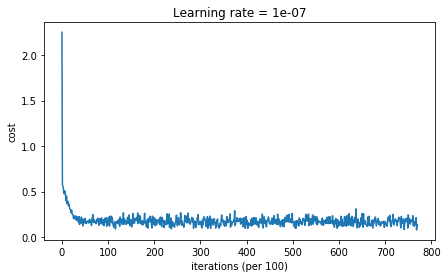

Stored 'parameters_v5' (dict)


In [3]:
#--------------------------------------------------------------------------------------------------------------------------------------
# train 3-layer model
layers_dims = [shuffled_X.shape[0], 530, 200, 1]
parameters_v5 = model(shuffled_X, shuffled_Y, layers_dims)
%store parameters_v5

#----------------------------------------------------------------------------------------------------------------------------------------


In [4]:
# Predict
#print ("On the training set:")
#predictions_training = predict(shuffled_X, shuffled_Y, parameters)
#print ("On the test set:")
#predictions_testing = predict(shuffled_X_test, shuffled_Y_test, parameters)


# train 3-layer simplified model
#layers_dims = [shuffled_X.shape[0], 10, 3, 1]
#parameters = model(shuffled_X, shuffled_Y, layers_dims)

# Predict
print ("On the training set:")
predictions_training = predict(shuffled_X, shuffled_Y, parameters_v5)
#print ("On the test set:")
#predictions_testing = predict(shuffled_X_test, shuffled_Y_test, parameters_v5)


On the training set:
Accuracy: 0.938440642170588


In [5]:
print ("On the test set:")
predictions_testing = predict(shuffled_X_test, shuffled_Y_test, parameters_v5)

On the test set:
Accuracy: 0.938901179941003
